- Soft Q Learning

In [1]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

10:16:22 [INFO] env: <LunarLander<LunarLander-v2>>
10:16:22 [INFO] action_space: Discrete(4)
10:16:22 [INFO] observation_space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
10:16:22 [INFO] reward_range: (-inf, inf)
10:16:22 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
10:16:22 [INFO] _max_episode_steps: 1000
10:16:22 [INFO] _elapsed_steps: None
10:16:22 [INFO] id: LunarLander-v2
10:16:22 [INFO] entry_point: gym.envs.box2d:LunarLander
10:16:22 [INFO] reward_threshold: 200
10:16:22 [INFO] nondeterministic: False
10:16:22 [INFO] max_episode_steps: 1000
10:16:22 [INFO] _kwargs: {}
10:16:22 [INFO] _env_name: LunarLander


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SQLAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.alpha = 0.02

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[256, 256], output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=3e-4)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation,
                dtype=torch.float).squeeze(0)
        q_div_alpha_tensor = self.evaluate_net(state_tensor) / self.alpha
        v_div_alpha_tensor = torch.logsumexp(q_div_alpha_tensor, dim=-1,
                keepdim=True)
        prob_tensor = (q_div_alpha_tensor - v_div_alpha_tensor).exp()
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 500:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(128) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_q_tensor = self.target_net(next_state_tensor)
        next_v_tensor = self.alpha * torch.logsumexp(next_q_tensor / self.alpha, dim=-1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * next_v_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(q_tensor, target_tensor.detach())
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = SQLAgent(env)

11:00:58 [INFO] ==== train ====


C:\Users\voidwu\Anaconda3\envs\drl-py39\lib\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


11:01:00 [DEBUG] train episode 0: reward = -461.18, steps = 83
11:01:01 [DEBUG] train episode 1: reward = -668.99, steps = 69
11:01:02 [DEBUG] train episode 2: reward = -458.32, steps = 73
11:01:03 [DEBUG] train episode 3: reward = -493.66, steps = 56
11:01:05 [DEBUG] train episode 4: reward = -546.61, steps = 76
11:01:06 [DEBUG] train episode 5: reward = -592.39, steps = 75
11:01:07 [DEBUG] train episode 6: reward = -591.07, steps = 68
11:01:08 [DEBUG] train episode 7: reward = 10.01, steps = 58
11:01:09 [DEBUG] train episode 8: reward = -101.41, steps = 53
11:01:10 [DEBUG] train episode 9: reward = -184.76, steps = 77
11:01:11 [DEBUG] train episode 10: reward = -127.31, steps = 61
11:01:13 [DEBUG] train episode 11: reward = -162.83, steps = 71
11:01:14 [DEBUG] train episode 12: reward = -151.20, steps = 79
11:01:16 [DEBUG] train episode 13: reward = -142.71, steps = 80
11:01:17 [DEBUG] train episode 14: reward = -159.48, steps = 66
11:01:18 [DEBUG] train episode 15: reward = -109.68,

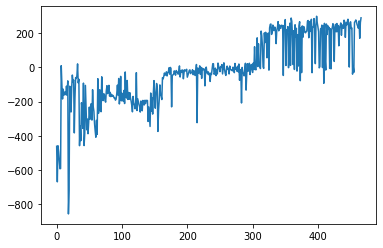

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train', render=True)
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent, render=True)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))